In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df = data.drop('img_name', axis=1)
columns = ["age", "gender"]
y = df.drop("pixels", axis=1)
X = df.drop(columns, axis=1)
X = pd.Series(X['pixels'])
X = X.apply(lambda x:x.split(' '))
X = X.apply(lambda x:np.array(list(map(lambda z:np.int(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)

# reshape data
X = X.reshape(-1, 48, 48, 1)
print("X shape: ", X.shape)

X shape:  (23705, 48, 48, 1)


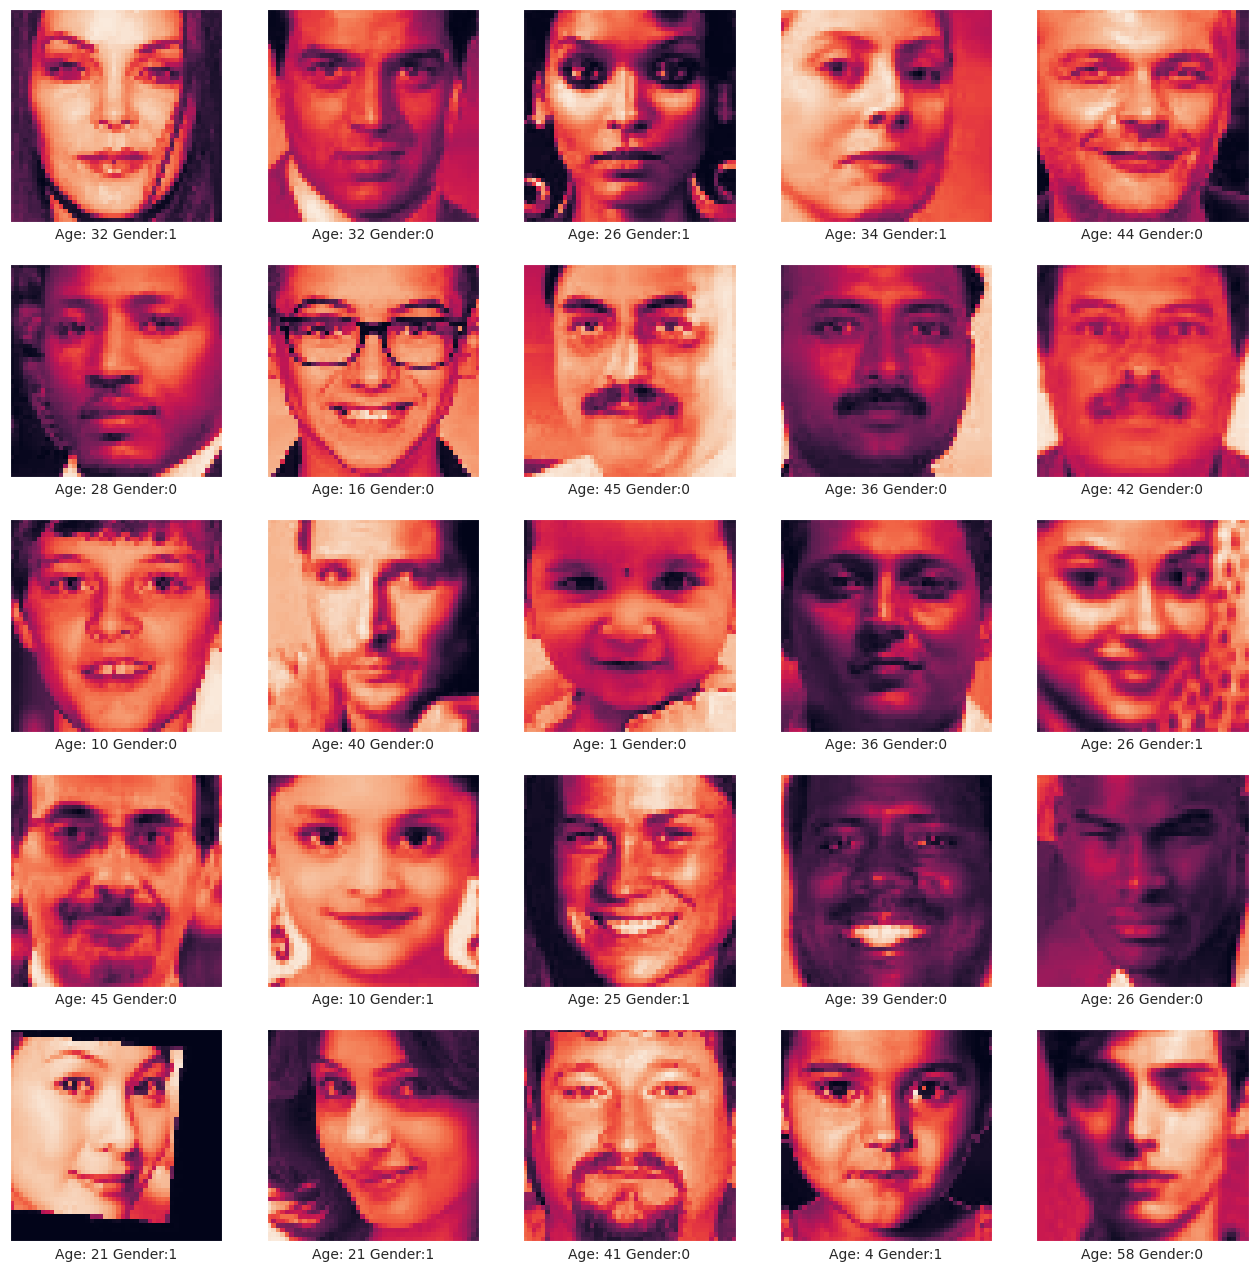

In [5]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()

In [6]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
age_matrix = np.array(y['age'])
gender_matrix = np.array(y['gender'])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
print(age, gender)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
X = X / 255

In [9]:
datagen = ImageDataGenerator(
        featurewise_center = False,
    # set input mean to 0 over the dataset
       samplewise_center = False,
    # set each sample mean to 0 
       featurewise_std_normalization = False,
    # divide inputs by std of the dataset
       samplewise_std_normalization=False,  
    # divide each input by its std
       zca_whitening=False,
    # dimesion reduction
       rotation_range=5, 
    # randomly rotate images in the range 5 degrees
       zoom_range = 0.1,
    # Randomly zoom image 10%
       width_shift_range=0.1, 
    # randomly shift images horizontally 10%
       height_shift_range=0.1,  
    # randomly shift images vertically 10%
       horizontal_flip=False,  
    # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X)

In [12]:
# Gender
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, gender, test_size=0.3, random_state=42)

# Age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, age, test_size=0.3, random_state=42)

In [13]:
print( X_train_gender.shape, X_train_age.shape)

(16593, 48, 48, 1) (16593, 48, 48, 1)


In [14]:
def my_model(num_classes, activation, loss):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(num_classes, activation=activation))
    
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model
early_stopping = EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                           patience = 2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

In [18]:
epochs = 25  
batch_size = 64
model_age = my_model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_age,y_test_age), 
                            steps_per_epoch= X_train_age.shape[0] // batch_size, 
                            callbacks= [early_stopping, 
                            learning_rate_reduction])

Epoch 1/25
259/259 [==============================] - 52s 194ms/step - loss: 0.9902 - accuracy: 0.6567 - val_loss: 4.7295 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 2/25
259/259 [==============================] - 51s 196ms/step - loss: 0.6774 - accuracy: 0.7319 - val_loss: 1.2568 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/25
259/259 [==============================] - 49s 191ms/step - loss: 0.6068 - accuracy: 0.7604 - val_loss: 0.8603 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 4/25
259/259 [==============================] - 50s 193ms/step - loss: 0.5638 - accuracy: 0.7777 - val_loss: 1.0673 - val_accuracy: 0.5873 - lr: 0.0010
Epoch 5/25
259/259 [==============================] - 50s 193ms/step - loss: 0.5227 - accuracy: 0.7958 - val_loss: 0.6588 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 6/25
259/259 [==============================] - 50s 192ms/step - loss: 0.4962 - accuracy: 0.8028 - val_loss: 0.9073 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 7/25
259/259 [==============================] 

In [19]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6495915651321411
Test Accuracy: 0.7512654662132263


In [20]:
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = (X_test_gender, y_test_gender),
                                 steps_per_epoch = X_train_gender.shape[0] // batch_size, callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/25
259/259 [==============================] - 53s 197ms/step - loss: 0.4767 - accuracy: 0.7866 - val_loss: 0.8097 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 2/25
259/259 [==============================] - 51s 198ms/step - loss: 0.3314 - accuracy: 0.8540 - val_loss: 0.3678 - val_accuracy: 0.8352 - lr: 0.0010
Epoch 3/25
259/259 [==============================] - 50s 194ms/step - loss: 0.2923 - accuracy: 0.8706 - val_loss: 0.2688 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/25
259/259 [==============================] - 50s 194ms/step - loss: 0.2572 - accuracy: 0.8864 - val_loss: 0.2865 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 5/25
259/259 [==============================] - 51s 197ms/step - loss: 0.2373 - accuracy: 0.8956 - val_loss: 0.2600 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 6/25
259/259 [==============================] - 51s 196ms/step - loss: 0.2187 - accuracy: 0.9051 - val_loss: 0.2554 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 7/25
259/259 [==============================] 

In [21]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))
#increasing number of epochs increases the accuracy

Test loss: 0.2553790211677551
Test Accuracy: 0.8942632079124451
